In [109]:
import os

from pymatgen.io.vasp.inputs import Structure
import numpy as np
import pandas as pd
#import r2score from sklearn.metrics
from sklearn.metrics import r2_score

from qubitPack.tool_box import get_db

from matplotlib import pyplot as plt
import scienceplots

plt.style.use(['science', 'notebook'])

zfs_db = get_db("qubit_sensor", "three_dim_strained_zfs", port=27017)
scf_db = get_db("qubit_sensor", "three_dim_strained", port=27017)

/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/atomate/atomate/utils/database.py:51: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if self.db.counter.find({"_id": "taskid"}).count() == 0:


In [110]:
def get_st_info(st, NN):
    top = 80
    bottom = 100
    distances = [st.get_distance(NN[-1], x) for x in NN[:-1]+[bottom]+[top]]
    z = [st.sites[NN[-1]].coords[-1] - st.sites[x].coords[-1] for x in NN[:-1]+[bottom]+[top]]
    a, b, c = st.lattice.a/5, st.lattice.b/5, st.lattice.c
    spg = st.get_space_group_info()[0]

    # give name for each data
    dis_name = [f"d{i}" for i in range(1, len(distances)+1)]
    z_name = [f"z{i}" for i in range(1, len(z)+1)]
    a_name, b_name, c_name = "a", "b", "c"
    spg_name = "spg"

    data = {}
    data.update(dict(zip(dis_name, distances)))
    data.update(dict(zip(z_name, z)))
    data.update({a_name: a, b_name: b, c_name: c, spg_name: spg, "NN": NN})
    return data


# Strained ZFS & structure

In [111]:
Ds = []
es = zfs_db.collection.find({"task_label": "pyzfs"})
for e in es:
    taskid = e["task_id"]
    prev_fw_taskid = e["prev_fw_taskid"]
    scf_entry = scf_db.collection.find_one({"task_id": prev_fw_taskid})
    data = {}
    formula = "".join(e["formula"].split(" "))
    D = e["pyzfs_out"]["D"]/1000
    E = e["pyzfs_out"]["E"]/1000
    strain_ratio = scf_entry["strain_ratio"]
    strain_comp = scf_entry["strain_component"] if "strain_component" in scf_entry else "xx_yy"
    if strain_ratio == 0:
        strain_comp ="pristine"
    data.update({"taskid": taskid, "formula": formula, "D": D, "E":E, "strain_ratio": strain_ratio, "strain_comp": strain_comp,
        "db_info": f"{zfs_db.db_name}.{zfs_db.collection.name}"})
    Ds.append(data)
zfs_df = pd.DataFrame(Ds).sort_values("strain_ratio")
display(zfs_df.round(2))

,taskid,formula,D,E,strain_ratio,strain_comp,db_info
0,218,Mo51S99,8.18,-0.0,-0.20,zz,qubit_sensor.three_dim_strained_zfs
2,220,Mo51S99,8.25,-0.0,-0.10,zz,qubit_sensor.three_dim_strained_zfs
7,233,Mo51S99,8.27,-0.0,-0.05,zz,qubit_sensor.three_dim_strained_zfs
1,219,Mo51S99,8.17,-0.0,0.00,pristine,qubit_sensor.three_dim_strained_zfs
3,221,Mo51S99,8.18,-0.0,0.05,zz,qubit_sensor.three_dim_strained_zfs
6,231,Mo51S99,8.18,-0.0,0.10,zz,qubit_sensor.three_dim_strained_zfs
5,227,Mo51S99,8.13,-0.0,0.15,zz,qubit_sensor.three_dim_strained_zfs
4,224,Mo51S99,8.15,-0.0,0.20,zz,qubit_sensor.three_dim_strained_zfs


In [112]:
st_df = []
es = zfs_db.collection.find({"task_label": "pyzfs"})
for e in es:
    prev_fw_taskid = e["prev_fw_taskid"]
    scf_entry = scf_db.collection.find_one({"task_id": prev_fw_taskid})
    st = Structure.from_dict(scf_entry["output"]["structure"])
    formula = scf_entry["formula_pretty"]
    nn = scf_entry["NN"][:3]+[scf_entry['NN'][-1]] #[5, 6, 0, 25]

    st0 = get_st_info(st, NN=nn)
    st0.update(
        {
            "taskid": e["task_id"],
            "formula": formula,
            "strain_ratio": scf_entry["strain_ratio"],
            "structure": st
        }
    )
    st_df.append(st0)
st_df = pd.DataFrame(st_df)
display(st_df.round(2))



/home/tsai/.conda/envs/workflow/lib/python3.7/site-packages/pymatgen/core/lattice.py:1364: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  fc = np.array(np.round(fc), dtype=np.int)


,d1,d2,d3,d4,d5,z1,z2,z3,z4,z5,a,b,c,spg,NN,taskid,formula,strain_ratio,structure
0,2.68,2.68,2.68,3.52,4.40,-1.98,-1.98,-1.98,-3.52,3.99,3.19,3.19,30.53,P3m1,"[29, 25, 30, 50]",218,Mo17S33,-0.20,"[[ 1.596119 -0.92151052 11.56624495] Mo, [ 3..."
1,2.71,2.71,2.71,3.55,3.70,-2.01,-2.01,-2.01,-3.55,3.21,3.19,3.19,29.82,P3m1,"[29, 25, 30, 50]",219,Mo17S33,0.00,"[[ 1.596119 -0.92151052 11.56733123] Mo, [ 3..."
2,2.69,2.69,2.69,3.54,4.04,-1.99,-1.99,-1.99,-3.54,3.59,3.19,3.19,30.17,P3m1,"[29, 25, 30, 50]",220,Mo17S33,-0.10,"[[ 1.596119 -0.92151052 11.5758132 ] Mo, [ 3..."
3,2.71,2.71,2.71,3.55,3.61,-2.02,-2.02,-2.02,-3.55,3.11,3.19,3.19,29.64,P3m1,"[29, 25, 30, 50]",221,Mo17S33,0.05,"[[ 1.596119 -0.92151052 11.52345588] Mo, [ 3..."
4,2.71,2.71,2.71,3.57,3.53,-2.02,-2.02,-2.02,-3.57,3.02,3.19,3.19,29.11,P3m1,"[29, 25, 30, 50]",224,Mo17S33,0.20,"[[ 1.596119 -0.92151052 11.28814522] Mo, [ 3..."
5,2.71,2.71,2.71,3.56,3.54,-2.02,-2.02,-2.02,-3.56,3.03,3.19,3.19,29.28,P3m1,"[29, 25, 30, 50]",227,Mo17S33,0.15,"[[ 1.596119 -0.92151052 11.37766535] Mo, [ 3..."
6,2.71,2.71,2.71,3.56,3.58,-2.02,-2.02,-2.02,-3.56,3.08,3.19,3.19,29.46,P3m1,"[29, 25, 30, 50]",231,Mo17S33,0.10,"[[ 1.596119 -0.92151052 11.45173145] Mo, [ 3..."
7,2.70,2.70,2.70,3.55,3.76,-2.01,-2.01,-2.01,-3.55,3.29,3.19,3.19,30.00,P3m1,"[29, 25, 30, 50]",233,Mo17S33,-0.05,"[[ 1.596119 -0.92151052 11.6323807 ] Mo, [ 3..."


In [113]:
# combine zfs and structure by taskid
strained_df = zfs_df.merge(st_df, on="taskid")
# remove _y
strained_df = strained_df.loc[:, ~strained_df.columns.str.endswith("_y")]
# rename _x
strained_df = strained_df.rename(columns={x: x[:-2] for x in strained_df.columns if x.endswith("_x")})
display(strained_df.round(2))

,taskid,formula,D,E,strain_ratio,strain_comp,db_info,d1,d2,d3,...,z2,z3,z4,z5,a,b,c,spg,NN,structure
0,218,Mo51S99,8.18,-0.0,-0.20,zz,qubit_sensor.three_dim_strained_zfs,2.68,2.68,2.68,...,-1.98,-1.98,-3.52,3.99,3.19,3.19,30.53,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.56624495] Mo, [ 3..."
1,220,Mo51S99,8.25,-0.0,-0.10,zz,qubit_sensor.three_dim_strained_zfs,2.69,2.69,2.69,...,-1.99,-1.99,-3.54,3.59,3.19,3.19,30.17,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.5758132 ] Mo, [ 3..."
2,233,Mo51S99,8.27,-0.0,-0.05,zz,qubit_sensor.three_dim_strained_zfs,2.70,2.70,2.70,...,-2.01,-2.01,-3.55,3.29,3.19,3.19,30.00,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.6323807 ] Mo, [ 3..."
3,219,Mo51S99,8.17,-0.0,0.00,pristine,qubit_sensor.three_dim_strained_zfs,2.71,2.71,2.71,...,-2.01,-2.01,-3.55,3.21,3.19,3.19,29.82,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.56733123] Mo, [ 3..."
4,221,Mo51S99,8.18,-0.0,0.05,zz,qubit_sensor.three_dim_strained_zfs,2.71,2.71,2.71,...,-2.02,-2.02,-3.55,3.11,3.19,3.19,29.64,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.52345588] Mo, [ 3..."
5,231,Mo51S99,8.18,-0.0,0.10,zz,qubit_sensor.three_dim_strained_zfs,2.71,2.71,2.71,...,-2.02,-2.02,-3.56,3.08,3.19,3.19,29.46,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.45173145] Mo, [ 3..."
6,227,Mo51S99,8.13,-0.0,0.15,zz,qubit_sensor.three_dim_strained_zfs,2.71,2.71,2.71,...,-2.02,-2.02,-3.56,3.03,3.19,3.19,29.28,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.37766535] Mo, [ 3..."
7,224,Mo51S99,8.15,-0.0,0.20,zz,qubit_sensor.three_dim_strained_zfs,2.71,2.71,2.71,...,-2.02,-2.02,-3.57,3.02,3.19,3.19,29.11,P3m1,"[29, 25, 30, 50]","[[ 1.596119 -0.92151052 11.28814522] Mo, [ 3..."


## Add dD and dE

In [114]:
# update strained_ratio for those with strain_ratio == -1 by calculating the ratio of the difference bewteen their a
# and the pristine a (strain_ratio == 0)
df = strained_df.copy()

#add dD = D(strain_ratio) - D(0)
df.loc[df["strain_ratio"] != 0, "dD"] = df.loc[df["strain_ratio"] != 0, "D"] - df.loc[df["strain_ratio"] == 0, "D"].iloc[0]
# if NaN, set to 0
df["dD"] = df["dD"].fillna(0)

#add dE = E(strain_ratio) - E(0)
df.loc[df["strain_ratio"] != 0, "dE"] = df.loc[df["strain_ratio"] != 0, "E"] - df.loc[df["strain_ratio"] == 0, "E"].iloc[0]
# if NaN, set to 0
df["dE"] = df["dE"].fillna(0)

# df["dD_ratio"] = df["dD_ratio"]


In [115]:
display(df.strain_comp)

0          zz
1          zz
2          zz
3    pristine
4          zz
5          zz
6          zz
7          zz
Name: strain_comp, dtype: object

## Separate df into different strain components

In [116]:
for strain_comp, d in df.groupby("strain_comp"):
    # claim a new df for each strain component
    print(strain_comp)
    if strain_comp == "pristine":
        continue
    exec(f"{strain_comp}_df = d")
    # add the row with strain_ratio == 0 to each df
    exec(f"{strain_comp}_df = {strain_comp}_df.append(df.loc[df.strain_ratio==0])")
    # sort by strain_ratio
    exec(f"{strain_comp}_df = {strain_comp}_df.sort_values('strain_ratio')")

pristine
zz


In [117]:
os.getcwd()

'/mnt/md18/work/tsai/Research/projects/quantum_sensor/analysis'

In [173]:
zz_df.iloc[7]["structure"].to("poscar", "../structure/pc/strained_pc/3D_TMDs/zz/-0.2:0.2/pristine.vasp")

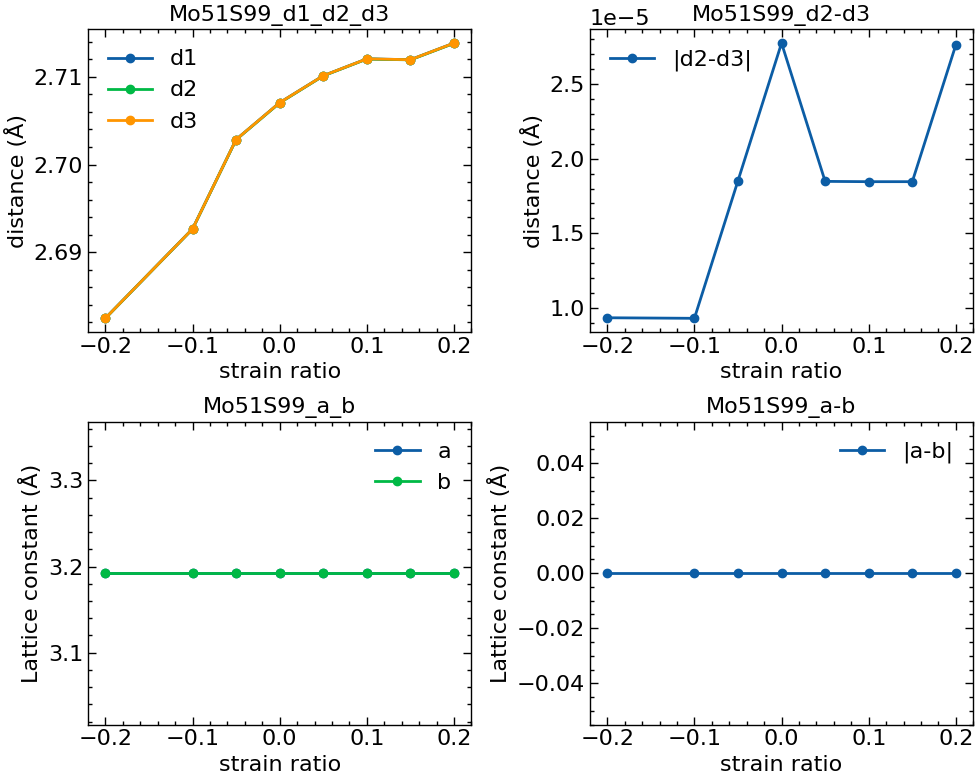

In [119]:
# plot d1, d2, and d3 for each strain component
for strain_comp in [zz_df]:
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(2, 2, 1)
    ax.plot(strain_comp["strain_ratio"], strain_comp["d1"], label="d1", marker="o")
    ax.plot(strain_comp["strain_ratio"], strain_comp["d2"], label="d2", marker="o")
    ax.plot(strain_comp["strain_ratio"], strain_comp["d3"], label="d3", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("distance (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_d1_d2_d3")
    ax.legend()

    ax = fig.add_subplot(2, 2, 2)
    d2_sub_d3 = strain_comp["d2"] - strain_comp["d3"]
    ax.plot(strain_comp["strain_ratio"], np.abs(d2_sub_d3), label="|d2-d3|", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("distance (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_d2-d3")
    ax.legend()

    # plot a and b
    ax = fig.add_subplot(2, 2, 3)
    ax.plot(strain_comp["strain_ratio"], strain_comp["a"], label="a", marker="o")
    ax.plot(strain_comp["strain_ratio"], strain_comp["b"], label="b", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("Lattice constant (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_a_b")
    ax.legend()

    #plot a-b
    ax = fig.add_subplot(2, 2, 4)
    ax.plot(strain_comp["strain_ratio"], np.abs(strain_comp["a"]-strain_comp["b"]), label="|a-b|", marker="o")
    ax.set_xlabel("strain ratio")
    ax.set_ylabel("Lattice constant (Å)")
    ax.set_title(strain_comp["formula"].iloc[0]+"_a-b")
    ax.legend()


    plt.tight_layout()
    plt.show()

In [120]:
# df.iloc[0]["structure"].to("poscar", "../structure/cubic_sc/strained_defect/95.vasp")

# ZFS plotting

## D & Structural info

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mo51S99
xrange_list: [(-0.2, 0.08), (0.3, 0.8)]
zfs_strain_ratio: 8, Ds: 8, strain_ratios: [-0.2  -0.1  -0.05  0.    0.05  0.1   0.15  0.2 ]
zfs_dz5: 6, Ds: 6, xrange: (-0.2, 0.08), dz5: [ 0.07741402  0.         -0.10025622 -0.13327953 -0.18150318 -0.18573763]
zfs_dz5: 2, Ds: 2, xrange: (0.3, 0.8), dz5: [0.78423634 0.38408424]


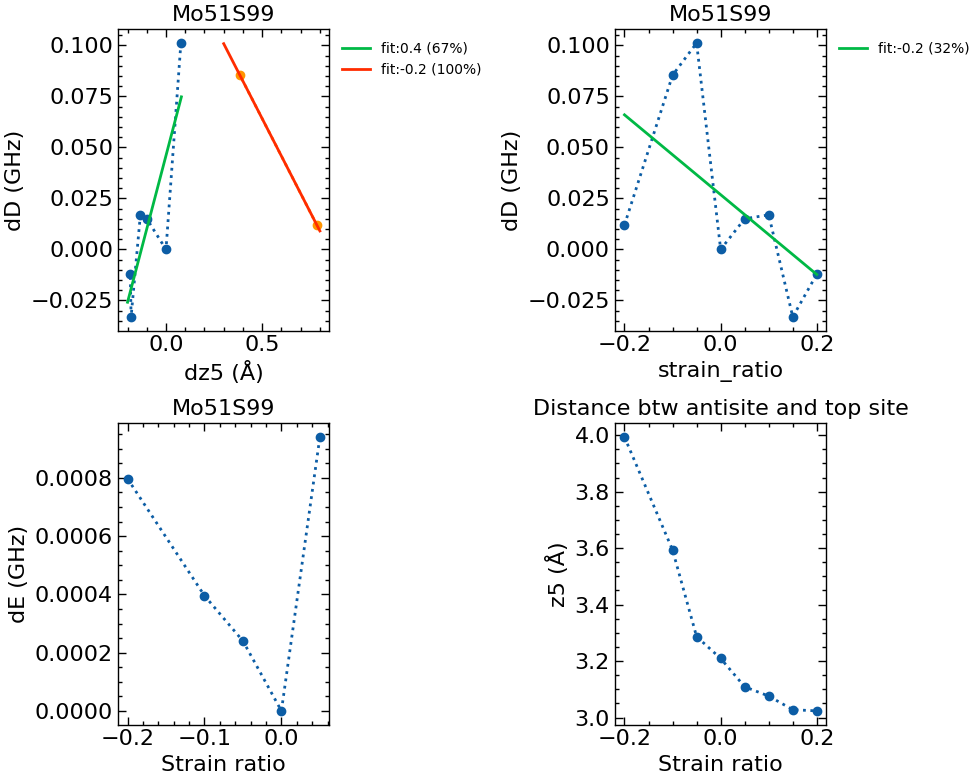

In [172]:
def plot_D_structure(plot_df, xrange_setting=None):
    for plt_idx, formula in enumerate(plot_df.sort_values(by="formula")["formula"].unique()):
        if "Te" in formula:
            continue
        fig = plt.figure(figsize=(10, 8))
        print(formula)
        zfs_all = plot_df.loc[(df["formula"] == formula)].sort_values("strain_ratio")
        xrange_setting = xrange_setting or {}
        xrange_min =  xrange_setting.get("xrange_min", -0.06)
        xrange_max = xrange_setting.get("xrange_max", 0.06)
        xrange_step = xrange_setting.get("xrange_step", 0.02)
        xrange_list = np.arange(xrange_min, xrange_max+xrange_step, xrange_step)
        # pair the xrange_list
        xrange_list = xrange_setting.get("xrange_list", list(zip(xrange_list[:-1], xrange_list[1:])))
        print(f"xrange_list: {xrange_list}")

    ############################3
        ax = fig.add_subplot(2, 2, 2)
        # fit with linear function and plot
        zfs = zfs_all.copy()
        strain_ratios = np.linspace(zfs.strain_ratio.min(), zfs.strain_ratio.max(), 100)
        Ds = zfs["dD"].values
        print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Ds: {len(Ds)}, strain_ratios: "
              f"{zfs.strain_ratio.values}")
        D_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Ds, 1))
        r2 = r2_score(zfs["dD"], D_fit(zfs["strain_ratio"]))
        slope = D_fit.coeffs[0].__round__(1)
        ax.plot(zfs["strain_ratio"], zfs["dD"], "o:")
        ax.plot(strain_ratios, D_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
        ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

        ax.set_ylabel("dD (GHz)")
        ax.set_xlabel("strain_ratio")
        ax.set_title(formula)

    ######################################3
        ax = fig.add_subplot(2, 2, 4)
        zfs = zfs_all.copy()
        zfs["dz"] = zfs["z5"] - zfs.loc[zfs["strain_ratio"] == 0]["z5"].values[0]
        a_sub_b = zfs["z5"]
        ax.set_ylabel("z5 (Å)")
        ax.plot(zfs["strain_ratio"], a_sub_b, "o:")

        ax.set_xlabel("Strain ratio")
        ax.set_title(f"Distance btw antisite and top site")
        ax.legend(fancybox=False, edgecolor="black")


    ###########################################3
        ax= fig.add_subplot(2, 2, 1)
        for idx, x_range in enumerate(xrange_list):
            zfs = zfs_all.copy()
            zfs["dz5"] = zfs["z5"] - zfs.loc[zfs["strain_ratio"] == 0]["z5"].values[0]
            zfs = zfs.loc[(zfs["dz5"]>=x_range[0]) & (zfs["dz5"]<=x_range[1])]
            # fit with linear function and plot
            strain_ratios = np.linspace(x_range[0], x_range[1], 100)
            Ds = zfs["dD"].values
            print(f"zfs_dz5: {len(zfs['dz5'])}, Ds: {len(Ds)}, xrange: {x_range}, dz5: {zfs.dz5.values}")
            D_fit = np.poly1d(np.polyfit(zfs["dz5"], Ds, 1))
            r2 = r2_score(zfs["dD"], D_fit(zfs["dz5"]))
            slope = D_fit.coeffs[0].__round__(1)
            ax.plot(zfs["dz5"], zfs["dD"], "o:")
            ax.plot(strain_ratios, D_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
            ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)

            ax.set_ylabel("dD (GHz)")
            ax.set_xlabel("dz5 (Å)")
            ax.set_title(formula)


        ax = fig.add_subplot(2, 2, 3)
        for idx, x_range in enumerate(xrange_list):
            zfs = zfs_all.loc[(zfs_all["strain_ratio"]>=x_range[0]) & (zfs_all["strain_ratio"]<=x_range[1])]
            # fit with linear function and plot
            # strain_ratios = np.linspace(x_range[0], x_range[1], 100)
            # Es = zfs["dE"].values
            # print(f"zfs_strain_ratio: {len(zfs['strain_ratio'])}, Es: {len(Es)}, xrange: {x_range}")
            # E_fit = np.poly1d(np.polyfit(zfs["strain_ratio"], Es, 1))
            # r2 = r2_score(zfs["dE"], E_fit(zfs["strain_ratio"]))
            # slope = E_fit.coeffs[0].__round__(1)
            ax.plot(zfs["strain_ratio"], zfs["dE"], "o:")
            # ax.plot(strain_ratios, E_fit(strain_ratios), "-", label=f"fit:{slope} ({r2:.0%})")
            ax.legend(fancybox=False, edgecolor="black", loc="upper left", bbox_to_anchor=(1, 1), fontsize=10)
            #
            ax.set_ylabel("dE (GHz)")
            ax.set_xlabel("Strain ratio")
            ax.set_title(formula)


        fig.tight_layout()
        return fig



# fig = plot_D_structure(xx_yy_df, xrange_setting={"xrange_list": [(-0.06, -0.03), (-0.03, -0.0095), (-0.0095, 0.02),
#                                                                  (0.02, 0.06)]})

# fig = plot_D_structure(xx_yy_df, xrange_setting={"xrange_list": [ (-0.03, -0.0095), (-0.0095, 0.008),]})

fig = plot_D_structure(zz_df, xrange_setting={"xrange_list": [(-0.2, 0.08), (0.3, 0.8)]})

fig.show()